In [1]:
import pandas as pd

df = pd.read_csv("../data/tricity_travel_03-25-2020_19-41-12.csv", index_col=0).reset_index(drop=True)
df.head()

stopName         stopDesc  zoneId zoneName   stopLat   stopLon  \
0  Św. Wojciech  Święty Wojciech     1.0   Gdańsk  54.28478  18.63808   
1    Olimpijska       Olimpijska     1.0   Gdańsk  54.30558  18.58112   
2       Maćkowy          Maćkowy     1.0   Gdańsk  54.30689  18.61525   
3    Przegalina       Przegalina     1.0   Gdańsk  54.31122  18.91707   
4    Kampinoska       Kampinoska     1.0   Gdańsk  54.31611  18.60301   

                          coord  time_sec  
0   54.28478000000001, 18.63808      3444  
1  54.305580000000006, 18.58112      2677  
2            54.30689, 18.61525      3240  
3            54.31122, 18.91707      5932  
4            54.31611, 18.60301      2791

In [2]:
Lat_max, Lat_min = df.stopLat.max(), df.stopLat.min()
Lon_max, Lon_min = df.stopLon.max(), df.stopLon.min()

In [3]:
map_3city_points = df[['stopLon', 'stopLat']].values

In [4]:
import numpy as np
from scipy.spatial import Voronoi

stops = df.coord.values
ids = np.array(map_3city_points)
vor = Voronoi(ids)
polygons = {}
for id, region_index in enumerate(vor.point_region):
    points = []
    for vertex_index in vor.regions[region_index]:
        if vertex_index != -1:  # the library uses this for infinity
            points.append(list(vor.vertices[vertex_index]))
    points.append(points[0])
    polygons[id]=points

In [5]:
stops_indexes = [row['coord'] for index, row in df.iterrows()]

In [6]:
data_geoJson = [{index: coordinates} for index, coordinates in zip(stops_indexes, polygons.values())]

In [7]:
from shapely.geometry import Point, LineString, Polygon

In [11]:
boundary_google = pd.read_csv("../src/state/tricity_boundary.csv", header=None)

In [15]:
boundary = np.array([[row[1], row[0]]for index, row in boundary_google.iterrows()])
boundary

array([[18.94036 , 54.280527],
       [18.904377, 54.314359],
       [18.872056, 54.311722],
       [18.761423, 54.333336],
       [18.727088, 54.340644],
       [18.690574, 54.301865],
       [18.630625, 54.27578 ],
       [18.597925, 54.284052],
       [18.541246, 54.312676],
       [18.527622, 54.334925],
       [18.503642, 54.334925],
       [18.485657, 54.319034],
       [18.459498, 54.3327  ],
       [18.466038, 54.353033],
       [18.440968, 54.356209],
       [18.428978, 54.384782],
       [18.465493, 54.40826 ],
       [18.442603, 54.406674],
       [18.438243, 54.438065],
       [18.442552, 54.457408],
       [18.390891, 54.493561],
       [18.357907, 54.49298 ],
       [18.405384, 54.528377],
       [18.39189 , 54.543165],
       [18.430871, 54.567799],
       [18.509333, 54.562004],
       [18.542817, 54.584021],
       [18.563807, 54.534756],
       [18.549314, 54.531567],
       [18.568305, 54.486013],
       [18.563307, 54.464234],
       [18.581299, 54.437503],
       [

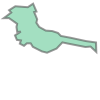

In [18]:
Polygon(boundary)

In [16]:
# boundary = np.array([[18.948932, 54.354509],
#                      [18.606983, 54.436059],
#                      [18.558918, 54.596288],
#                      [18.341938, 54.594697],
#                      [18.411136, 54.388688],
#                      [18.539508, 54.264611],
#                      [18.929380, 54.297227]])

In [17]:
boundary_3city = Polygon(boundary).buffer(0.00001)
data_geoJson_boundary = []
empty_test = []
for area in data_geoJson:
    for k, v in area.items():
        poly = Polygon(list(v)).buffer(0.00001)
        new_poly = boundary_3city.intersection(poly)
        empty_test.append(new_poly.is_empty)
        if not new_poly.is_empty:
            data_geoJson_boundary.append({k:[[x, y] for x, y in zip(new_poly.exterior.coords.xy[0],
                                                                    new_poly.exterior.coords.xy[1])]})
        else:
            data_geoJson_boundary.append(area)
len(data_geoJson_boundary)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
set(empty_test)

In [ ]:
data_geoJson[260]

In [ ]:
cell = Polygon(list(data_geoJson[260].values())[0]).buffer(0.00001)

new_polygon = cell.intersection(boundary_3city)

In [ ]:
cell

In [ ]:
boundary_3city

In [ ]:
new_polygon

In [1]:
import logging

In [ ]:
geoJson_3city = {"type":"FeatureCollection","features":[
                    {"type":"Feature",
                     "id":list(zone.keys())[0],
                     "properties":{"name":"3city"},
                     "geometry":{"type":"Polygon",
                                 "coordinates": list(zone.values())}} for zone in data_geoJson_boundary]}

In [ ]:
import json
with open('../src/state/geoJson_3city_boundary.json', 'w') as fp:
    json.dump(geoJson_3city, fp)

In [5]:
import folium
import os
import numpy as np


city_geo = os.path.join('../src/state/', 'geoJson_3city_boundary.json')

time_data = pd.read_csv("../data/tricity_travel_03-25-2020_19-41-12.csv", index_col=0).reset_index(drop=True).\
                                                             rename(columns={'coord':'id'})
time_data['time_min'] = time_data['time_sec'] / 60

threshold_scale = np.linspace(0, 60, 6, dtype=int) 
threshold_scale = threshold_scale.tolist()

m = folium.Map(location=[54.441564, 18.562754], zoom_start = 10)

folium.Choropleth(
    geo_data=city_geo,
    name='choropleth',
    data=time_data,
    columns=['id', 'time_min'],
    key_on='feature.id',
    line_weight=2,
    fill_color='YlOrRd',
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name='Time (min)',
    bins=9,
    reset=True
).add_to(m)

df['Lat'] = df['stopLat'].astype(float)
df['Lon'] = df['stopLon'].astype(float)

heat_df = df[['Lat', 'Lon']]
heat_data = [[row['Lat'], row['Lon']] for index, row in heat_df.iterrows()]

for index, row in heat_df.iterrows():
    folium.Circle(location=[row['Lat'], row['Lon']],
                  radius=10,
                  color=None,
                  fill=True,
                  fill_color="black",
                  fill_opacity=1).add_to(m)

m#.save("folium_choropleth_3city.html")